# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

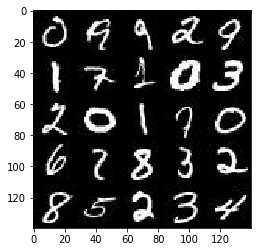

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

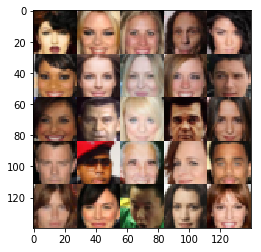

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),'inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), 'inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):

        alpha = 0.2

        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)

        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)

        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)

        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2

        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)

        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)

        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)

        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
            
                if steps % 20 == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_input, img_channels, data_image_mode) 
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2706... Generator Loss: 1.7819
Epoch 1/2... Discriminator Loss: 0.7652... Generator Loss: 1.2349
Epoch 1/2... Discriminator Loss: 0.3232... Generator Loss: 2.1138
Epoch 1/2... Discriminator Loss: 0.2203... Generator Loss: 7.0718
Epoch 1/2... Discriminator Loss: 0.7139... Generator Loss: 0.8385


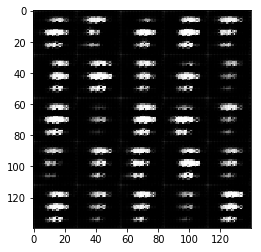

Epoch 1/2... Discriminator Loss: 0.1577... Generator Loss: 3.2133
Epoch 1/2... Discriminator Loss: 0.2588... Generator Loss: 2.4206
Epoch 1/2... Discriminator Loss: 2.0364... Generator Loss: 0.2826
Epoch 1/2... Discriminator Loss: 0.7008... Generator Loss: 2.8082
Epoch 1/2... Discriminator Loss: 0.0933... Generator Loss: 3.6167


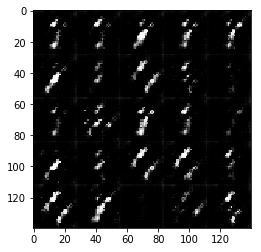

Epoch 1/2... Discriminator Loss: 0.2665... Generator Loss: 2.2696
Epoch 1/2... Discriminator Loss: 0.1564... Generator Loss: 3.2815
Epoch 1/2... Discriminator Loss: 0.3659... Generator Loss: 1.5937
Epoch 1/2... Discriminator Loss: 0.6673... Generator Loss: 1.3327
Epoch 1/2... Discriminator Loss: 0.2614... Generator Loss: 2.3747


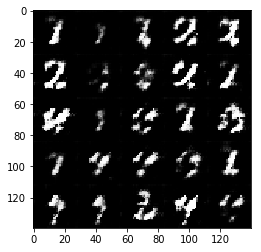

Epoch 1/2... Discriminator Loss: 0.4306... Generator Loss: 1.9821
Epoch 1/2... Discriminator Loss: 0.5710... Generator Loss: 2.2419
Epoch 1/2... Discriminator Loss: 0.4059... Generator Loss: 1.7078
Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 0.5601... Generator Loss: 2.0923


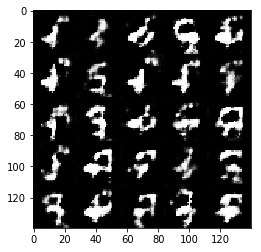

Epoch 1/2... Discriminator Loss: 0.5436... Generator Loss: 2.5774
Epoch 1/2... Discriminator Loss: 0.4759... Generator Loss: 1.5943
Epoch 1/2... Discriminator Loss: 0.4819... Generator Loss: 2.1458
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 1.7637


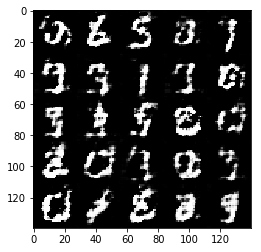

Epoch 1/2... Discriminator Loss: 1.7153... Generator Loss: 5.2302
Epoch 1/2... Discriminator Loss: 0.7154... Generator Loss: 1.8455
Epoch 1/2... Discriminator Loss: 0.6911... Generator Loss: 1.8404
Epoch 1/2... Discriminator Loss: 0.7678... Generator Loss: 1.3966
Epoch 1/2... Discriminator Loss: 0.6757... Generator Loss: 1.5554


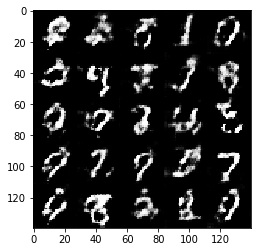

Epoch 1/2... Discriminator Loss: 0.8263... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 0.5945... Generator Loss: 1.9605
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.4712
Epoch 1/2... Discriminator Loss: 0.7652... Generator Loss: 2.9088


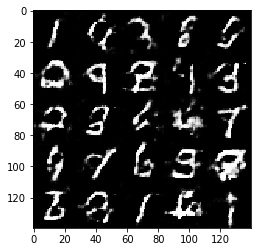

Epoch 1/2... Discriminator Loss: 0.7001... Generator Loss: 1.0757
Epoch 1/2... Discriminator Loss: 0.7029... Generator Loss: 2.9682
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.5756
Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 1.3999
Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 0.8679


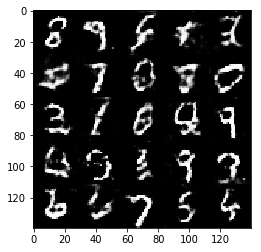

Epoch 1/2... Discriminator Loss: 0.6841... Generator Loss: 1.3919
Epoch 1/2... Discriminator Loss: 0.7604... Generator Loss: 2.9277
Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 0.7921
Epoch 1/2... Discriminator Loss: 0.7430... Generator Loss: 1.3023
Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 2.0209


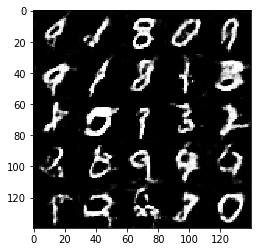

Epoch 1/2... Discriminator Loss: 0.6498... Generator Loss: 1.6969
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 0.5810
Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 0.5197
Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 1.2973
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.4881


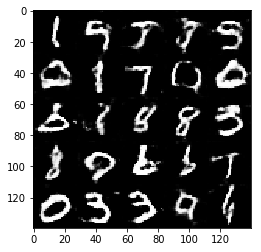

Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.5857
Epoch 2/2... Discriminator Loss: 0.5264... Generator Loss: 1.7035
Epoch 2/2... Discriminator Loss: 1.4089... Generator Loss: 1.7879
Epoch 2/2... Discriminator Loss: 0.8231... Generator Loss: 1.3191
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.8076


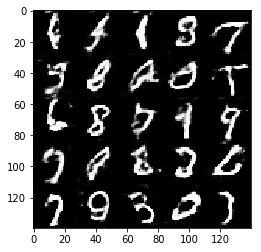

Epoch 2/2... Discriminator Loss: 1.2628... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 0.8590
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 0.6670... Generator Loss: 1.3404
Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 0.6605


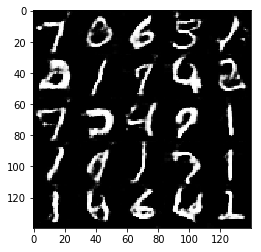

Epoch 2/2... Discriminator Loss: 1.1526... Generator Loss: 0.6138
Epoch 2/2... Discriminator Loss: 0.6950... Generator Loss: 1.8632
Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 0.7057... Generator Loss: 1.2213
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 2.3146


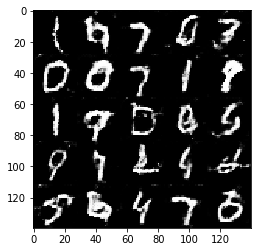

Epoch 2/2... Discriminator Loss: 0.8753... Generator Loss: 1.3669
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 1.0279... Generator Loss: 0.7162
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.6384
Epoch 2/2... Discriminator Loss: 0.6997... Generator Loss: 1.9807


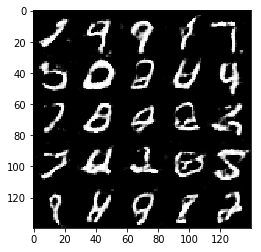

Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.6480
Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 2.2346
Epoch 2/2... Discriminator Loss: 1.5050... Generator Loss: 0.3931
Epoch 2/2... Discriminator Loss: 0.6574... Generator Loss: 1.3479
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 0.5342


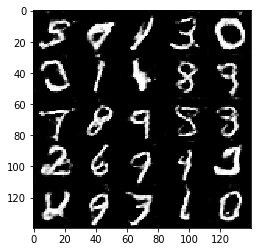

Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 0.6614
Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 3.3150
Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.4566
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 1.0183
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 0.5041


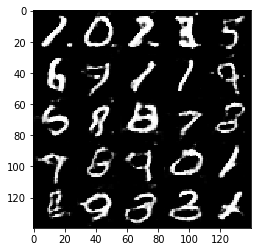

Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 0.9607... Generator Loss: 0.7399
Epoch 2/2... Discriminator Loss: 0.7597... Generator Loss: 1.2618
Epoch 2/2... Discriminator Loss: 0.5198... Generator Loss: 1.9347
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 0.7517


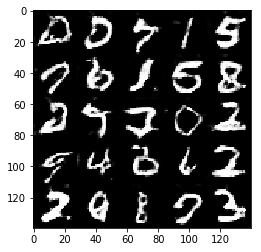

Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 2.0413
Epoch 2/2... Discriminator Loss: 0.7469... Generator Loss: 1.2081
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.4198
Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 1.4749


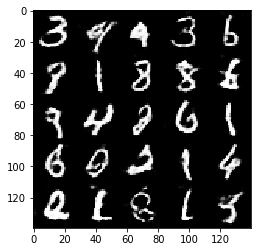

Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.4268
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 2.3541
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.6485


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 7.5143
Epoch 1/1... Discriminator Loss: 1.6757... Generator Loss: 0.3616
Epoch 1/1... Discriminator Loss: 0.2074... Generator Loss: 4.2120
Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 6.7622
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 1.3011


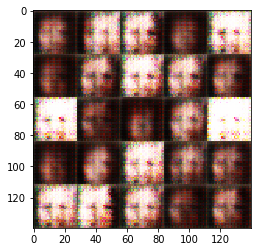

Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 2.0481... Generator Loss: 0.2604
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 2.0300
Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 2.1401
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 1.6760


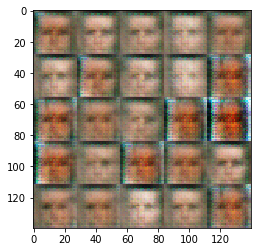

Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 2.9426
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.0689


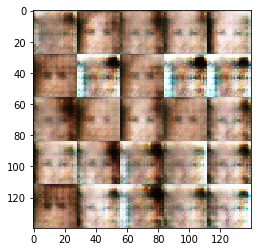

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 1.7926
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 9.0215... Generator Loss: 9.9130
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 1.0167


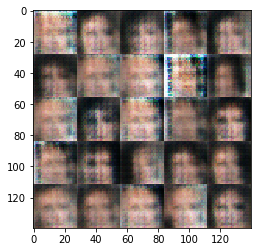

Epoch 1/1... Discriminator Loss: 0.5728... Generator Loss: 2.4542
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 1.4721
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.1045
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.9438


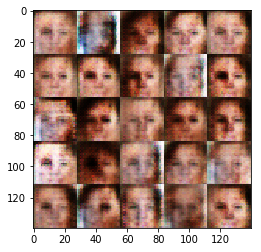

Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.3371
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.6233
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.1962


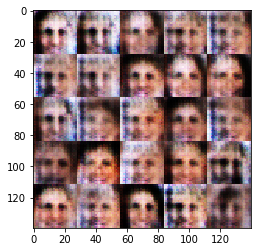

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 2.5290
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.1438


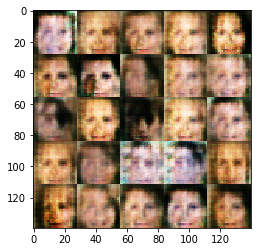

Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 1.6562
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.8446
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 1.1737


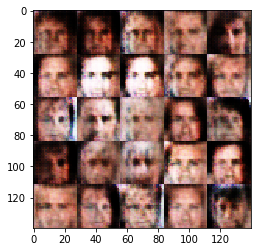

Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 1.2835
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.4756
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.5640
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.2564


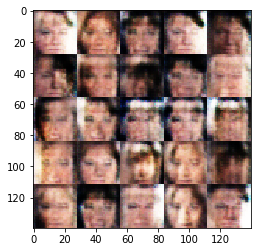

Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.6903
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.6529
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 2.3280


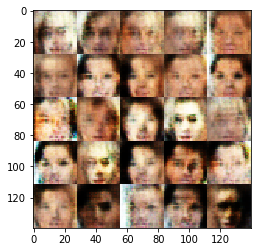

Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 0.8982


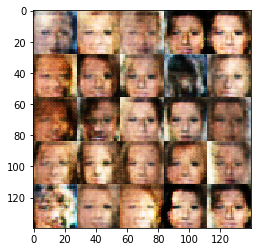

Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 2.2582
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.5687


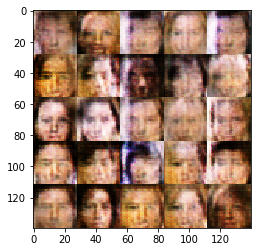

Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.6572
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.7392
Epoch 1/1... Discriminator Loss: 1.6868... Generator Loss: 0.3249


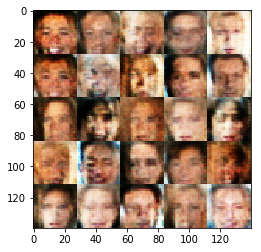

Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.3302
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.8262... Generator Loss: 0.2404


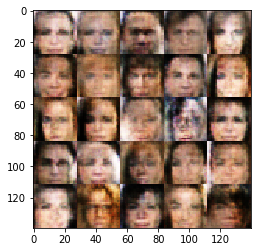

Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 1.6818
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.7310
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.5715
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 1.2285


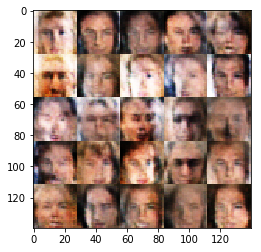

Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.3118


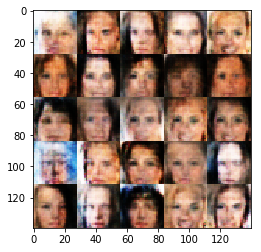

Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.8685
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 2.7038
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.5784


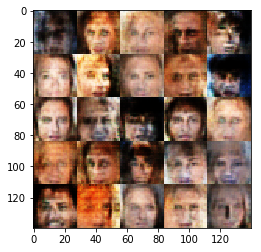

Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.8443
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.5646


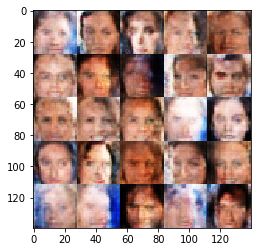

Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 1.4666
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 2.3677
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.3721
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.1011


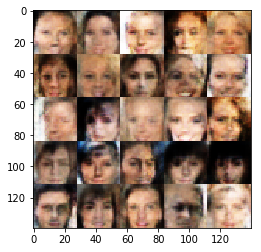

Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 2.4200
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.3254


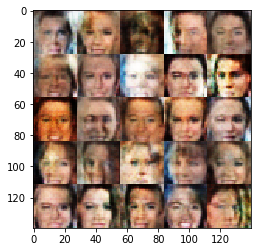

Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 1.6535
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 2.0806


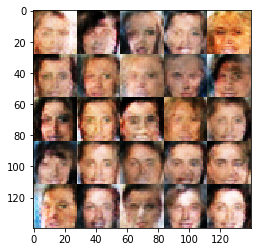

Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.3199
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.5134
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.2441


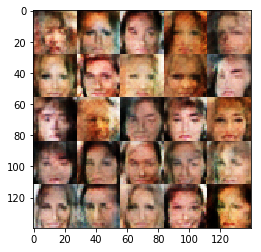

Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.5533
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.5152
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 2.0458


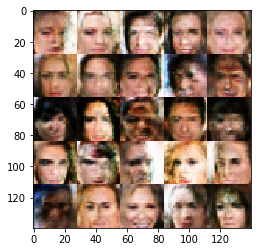

Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.8747
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 1.8555
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 1.6150


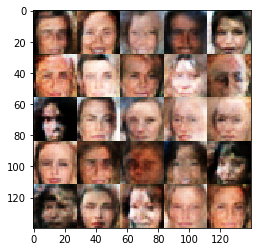

Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.1900


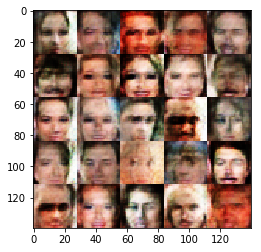

Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.1780


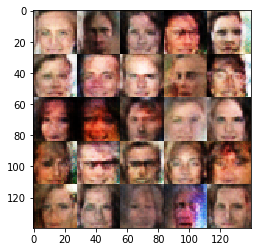

Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.4346
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.8520


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.